# Prerequisites

In [1]:
import sys

sys.path.append("..")

In [2]:
import argparse
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.display import display
from torchvision.models import resnet18, resnet50
from tqdm.notebook import tqdm

from dataset import (
    get_dloader,
    normalize_hw,
    normalize_hw_mask,
    normalize_inv_hw,
    normalize_inv_hw_mask,
)
from perlin import get_rgb_fractal_noise
from util import eval_step, get_obj_score, get_performance, get_saliency

C:\Users\runes\.conda\envs\context\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [3]:
data_dir = "../data"
class_legend = ("Siberian Husky", "Grey Wolf")
model_types = {"r18": "ResNet 18", "r50": "Resnet 50"}

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")


def get_model(model_type, device="cpu", seed=191510):
    torch.manual_seed(seed)
    if model_type == "r18":
        model = resnet18(weights=None)
    elif model_type == "r50":
        model = resnet50(weights=None)
    model.fc = torch.nn.Linear(
        in_features=model.fc.in_features, out_features=len(class_legend), bias=True
    )
    model.to(device)
    return model

Using device: cuda


# Evaluation

In [4]:
model_type = "r18"
split = "test"
# run_dir = "../models/hw-checkpoints/run-20240314-213449"
# run_dir = "../models/hw-checkpoints/run-20240317-161421"
# run_dir = "../models/hw-checkpoints/run-20240318-153036" # r18 perlin patient
# run_dir = "../models/hw-checkpoints/run-20240403-154614" # r18 sp loss test
# run_dir = "../models/hw-checkpoints/run-20240403-172544" # r18 sp loss full
run_dir = "../models/hw-checkpoints/run-20240404-152631" # r18 sp loss full finished



names = [p for p in os.listdir(run_dir) if os.path.isdir(f"{run_dir}/{p}")]
models = {name: get_model(model_type, device=device) for name in names}

cpts = {}
for name in names:
    m_cpts = os.listdir(f"{run_dir}/{name}")
    max_epoch = -1
    for cpt in m_cpts:
        if "best" in cpt:
            cpts[name] = cpt
            break
        epoch = int(cpt.split("_")[1].split(".")[0][1:])
        if epoch > max_epoch:
            cpts[name] = cpt
            max_epoch = epoch
print(cpts)

for name in models:
    checkpoint = torch.load(f"{run_dir}/{name}/{cpts[name]}")
    models[name].load_state_dict(checkpoint["model_state_dict"])
    models[name].eval()

all_labels = []
all_preds = {i + j: list() for i in models for j in models}
all_obj_scores = {i + j: list() for i in models for j in models}

dloader = get_dloader(split, batch_size=1, data_dir='../data', noise=True, num_workers=0)

for imgs, labels, masks, noise in tqdm(dloader):
    im, label, mask = imgs[0], labels[0], masks[0]
    
    inputs = {"a": normalize_hw(imgs), "b": normalize_hw_mask(imgs) * masks, "c": normalize_hw_mask(imgs * masks + noise * (~masks))}

    outs = {k0: {k1: None for k1 in inputs} for k0 in models}
    obj_scores = {k0: {k1: None for k1 in inputs} for k0 in models}

    for k_model, outs_model in outs.items():
        for k, v in inputs.items():
            outs_model[k] = get_saliency(models[k_model], v, device=device)

    for k_model, obj_scores_model in obj_scores.items():
        for k, (slc, _, _, _) in outs[k_model].items():
            obj_scores_model[k] = get_obj_score(slc, masks)

    all_labels.append(label.item())

    for k_model, outs_model in outs.items():
        for k_input, (_, _, indices, _) in outs_model.items():
            all_preds[k_model + k_input].append(indices.item())

    for k_model, obj_scores_model in obj_scores.items():
        for k_input, obj_score in obj_scores_model.items():
            all_obj_scores[k_model + k_input].append(obj_score)

all_labels = np.array(all_labels)
for k, v in all_preds.items():
    all_preds[k] = np.array(v)

for k, v in all_obj_scores.items():
    all_obj_scores[k] = np.array(v)


{'a': 'r18_e352_best.cpt', 'b': 'r18_e627_best.cpt', 'c': 'r18_e636_best.cpt'}


  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
accuracy = {}
mean_obj_scores = {}
for k, v in all_preds.items():
    accuracy[k] = (all_labels == v).mean()

for k, v in all_obj_scores.items():
    mean_obj_scores[k] = v.mean()

cols = {"a": "A", "b": "B", "c": "C"}
rows = {"a": "natural", "b": "masked", "c": "masked+noise"}

acc_df = pd.DataFrame.from_dict(
    {
        r_v: {c_v: accuracy[c_k + r_k] for c_k, c_v in cols.items()}
        for r_k, r_v in rows.items()
    },
    orient="index",
)
obj_score_df = pd.DataFrame.from_dict(
    {
        r_v: {c_v: mean_obj_scores[c_k + r_k] for c_k, c_v in cols.items()}
        for r_k, r_v in rows.items()
    },
    orient="index",
)

print('Accuracy')
display(acc_df)
print('Object score')
display(obj_score_df)

Accuracy


,A,B,C
natural,0.93,0.65,0.80
masked,0.73,0.91,0.92
masked+noise,0.84,0.68,0.92


Object score


,A,B,C
natural,0.747039,0.647163,0.744143
masked,0.791288,0.875475,0.918509
masked+noise,0.758178,0.655172,0.916258


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


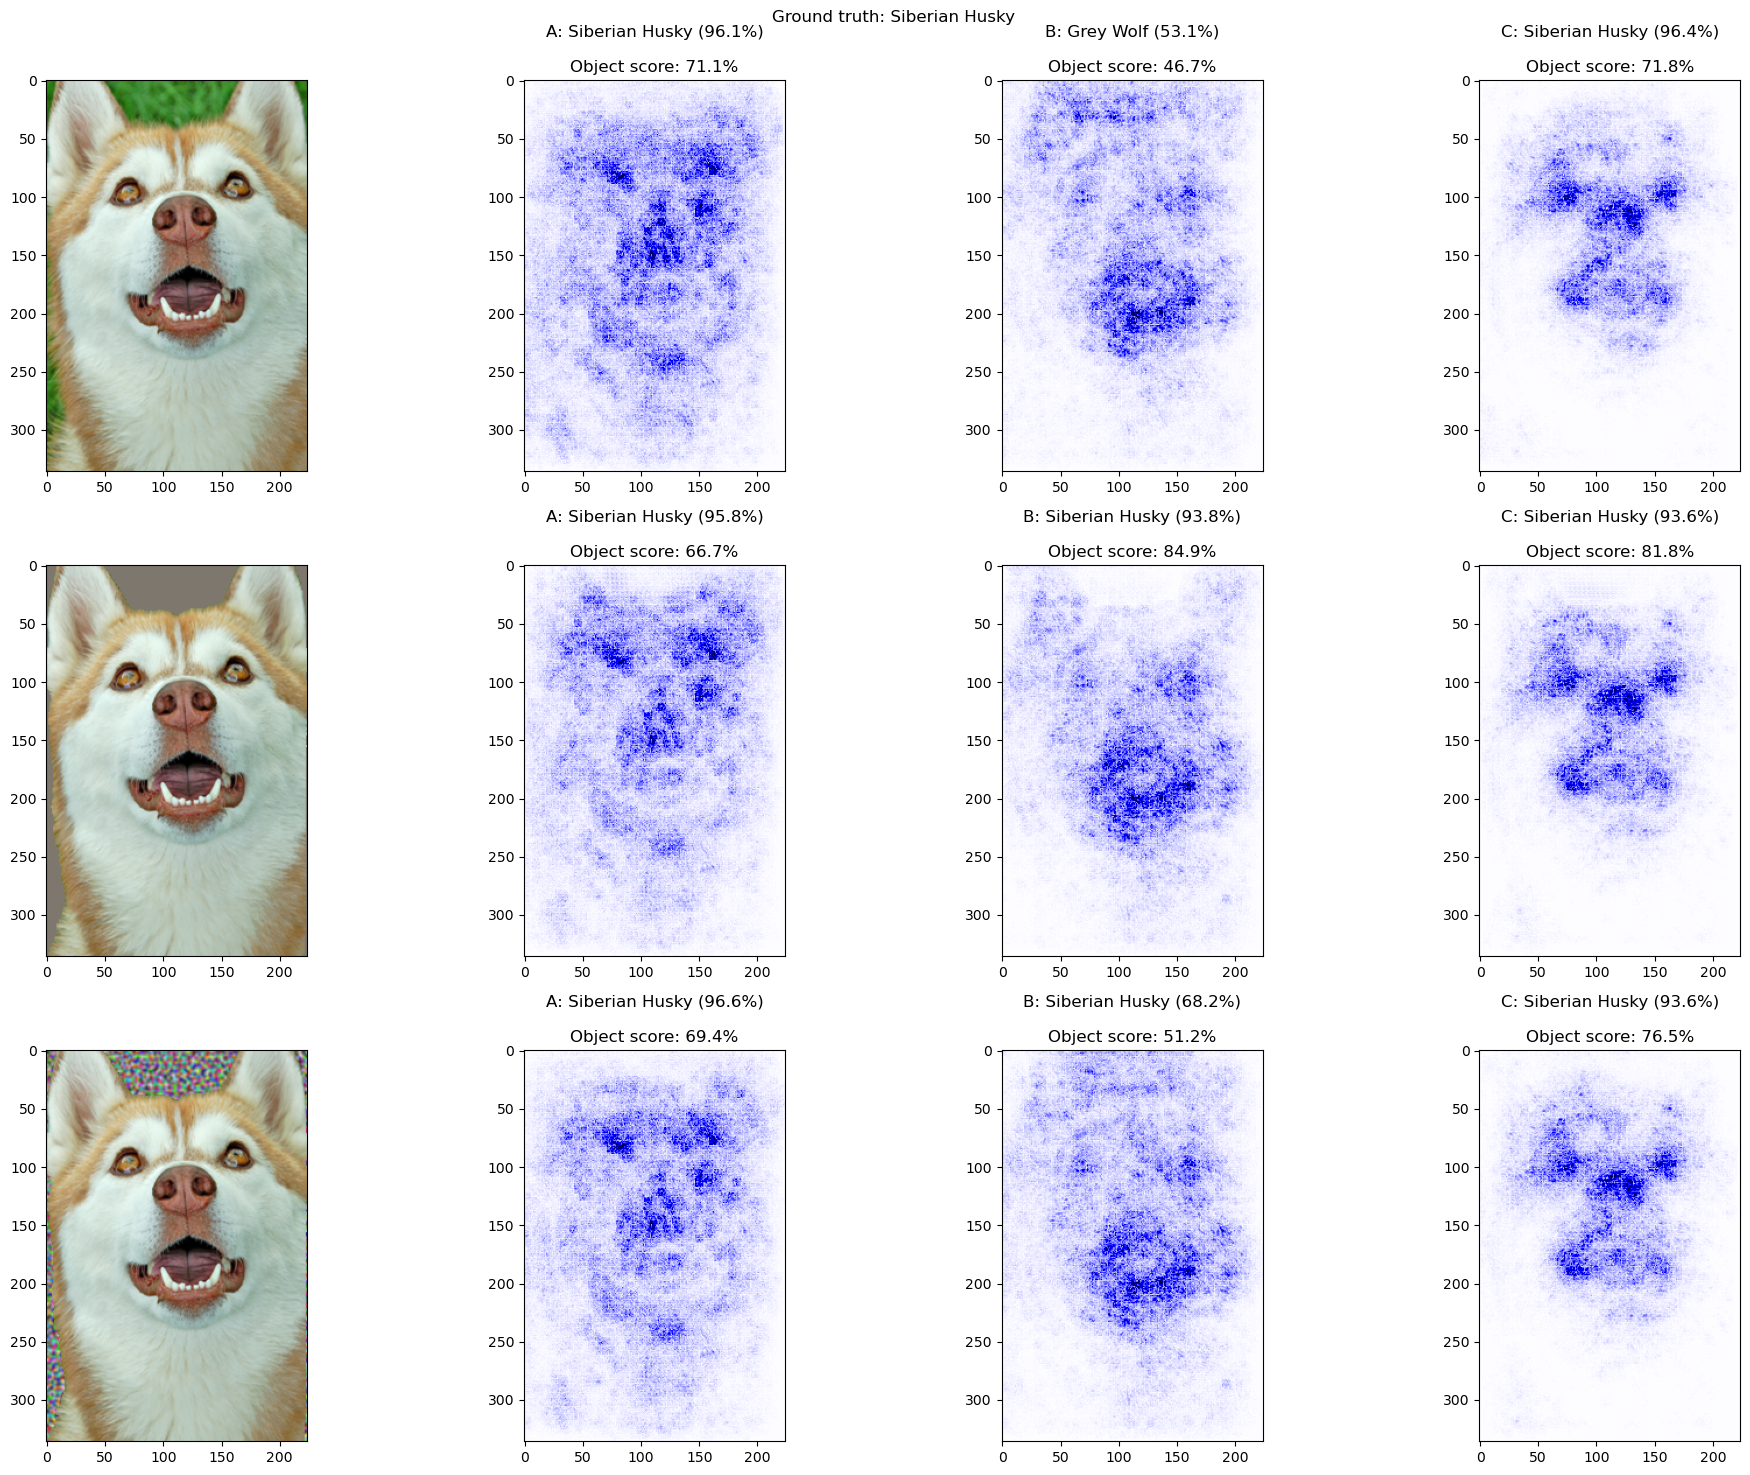

In [34]:
for imgs, labels, masks, noise in dloader:
    im, label, mask = imgs[0], labels[0], masks[0]
    
    inputs = {"a": normalize_hw(imgs), "b": normalize_hw_mask(imgs) * masks, "c": normalize_hw_mask(imgs * masks + noise * (~masks))}
    inv = {"a": normalize_inv_hw, "b": normalize_inv_hw_mask, "c": normalize_inv_hw_mask}

    outs = {k0: {k1: None for k1 in inputs} for k0 in models}
    obj_scores = {k0: {k1: None for k1 in inputs} for k0 in models}
    confs = {k0: {k1: None for k1 in inputs} for k0 in models}

    for k_model, outs_model in outs.items():
        for k, v in inputs.items():
            outs_model[k] = get_saliency(models[k_model], v, device=device)

    for k_model, obj_scores_model in obj_scores.items():
        for k, (slc, _, _, _) in outs[k_model].items():
            obj_scores_model[k] = get_obj_score(slc, masks)

    for k_model, confs_model in confs.items():
        for k, (_, _, indices, out) in outs[k_model].items():
            confs_model[k] = torch.softmax(out, 1)[0, indices]

    # mask = masks[0, 0].numpy().astype(bool)

    fig, axs_all = plt.subplots(3, 4, figsize=(20, 15), tight_layout=True)
    fig.suptitle(f"Ground truth: {class_legend[label.item()]}")
    for in_name, axs in zip(inputs, axs_all):

        axs[0].imshow(np.moveaxis(inv[in_name](inputs[in_name][0]).numpy(), 0, -1))
        for model_name, ax in zip(models, axs[1:]):
            slc, _, indices, out = outs[model_name][in_name]
            # ax.imshow((slc + 1) / 2, cmap="seismic", vmin=0, vmax=1)
            ax.imshow(np.abs(slc), cmap="seismic_r", vmin=-.6, vmax=.6)
            # ax.imshow(np.abs(slc), cmap="afmhot", vmin=0, vmax=.5)
            ax.set_title(
                f"{model_name.upper()}: {class_legend[indices.item()]} ({confs[model_name][in_name].item():.1%})\n\nObject score: {obj_scores[model_name][in_name]:.1%}"
            )

    plt.show()
    break